In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0-dev20210420


In [7]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 256, 256, 3])
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('ESRGAN.tflite', 'wb') as f:
  f.write(tflite_model)

esrgan_model_path = './ESRGAN.tflite'

In [8]:
test_img_path = tf.keras.utils.get_file('cayman.jpg', 'https://www.officinaveneziani.com/c/1290-medium_default/cayman.jpg')

8192/7193 [==================================] - 0s 0us/step


In [9]:
cayman = cv2.imread(test_img_path)
cayman = cv2.cvtColor(cayman, cv2.COLOR_BGR2RGB)
cayman = tf.expand_dims(cayman, axis=0)
cayman = tf.cast(cayman, tf.float32)

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=esrgan_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run the model
interpreter.set_tensor(input_details[0]['index'], cayman)
interpreter.invoke()

# Extract the output and postprocess it
output_data = interpreter.get_tensor(output_details[0]['index'])
sr = tf.squeeze(output_data, axis=0)
sr = tf.clip_by_value(sr, 0, 255)
sr = tf.round(sr)
sr = tf.cast(sr, tf.uint8)

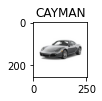

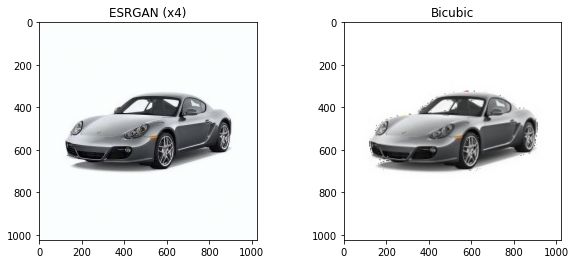

In [10]:
cayman = tf.cast(tf.squeeze(cayman, axis=0), tf.uint8)
plt.figure(figsize = (1, 1))
plt.title('CAYMAN')
plt.imshow(cayman.numpy());

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'ESRGAN (x4)')
plt.imshow(sr.numpy());

bicubic = tf.image.resize(cayman, [1024, 1024], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());